In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from IPython.display import Image
from IPython.display import display

%matplotlib inline

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso 
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.svm import LinearSVR

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
import warnings
warnings.filterwarnings('ignore')

## Import variable descriptions

import glob
import re# get variable description

def extract_section(file):
    section = re.sub(".*_S","S",file)
    section = re.sub("01_metadata.csv","",section)
    return(section)

year_meta = 2010

l_files = glob.glob("../Raw Data/aff_download (%i)/New folder/*.csv"%year_meta) 

df_meta = pd.DataFrame()

for s_file in l_files:
    s_section = extract_section(s_file)
    df_meta_local = pd.read_csv(s_file, header=None)
    df_meta_local.columns = ["variable","description"]
    df_meta_local["section"] = s_section
    df_meta = df_meta.append(df_meta_local)

 
df_meta["variable"] =  df_meta["section"] + "_" + df_meta["variable"]
df_meta = df_meta.drop(axis=1,labels="section")
df_meta.head()

def get_descriptions(l_vars,df_meta):
    return(df_meta[df_meta.variable.isin(l_vars)])

get_descriptions(["S01_HC01_EST_VC01","S01_HC01_EST_VC03"],df_meta)

## Import cleaned crime data
# Create murder per million variable

df_crime = pd.read_csv("../Processed Data/cleanedDataPreImputation_Dummies.csv", encoding='latin-1')

df_crime.head()

one_million = 1000000

df_crime["murder_fbi_per_million"] = df_crime.murder_fbi/df_crime.population_fbi *one_million


## Train test split and imputing by mean of train

df_train = df_crime[df_crime["year"]<=2013]
df_test = df_crime[df_crime["year"]>2013]

df_test = df_test[~pd.isnull(df_test.murder_fbi)]

missing = df_train.agg(func = lambda x: np.mean(pd.isnull(x)))

y_var = "murder_fbi_per_million"
y_var_count = "murder_fbi"
population_var = "population_fbi"
x_vars = pd.Series(missing[ missing < .20].index)


vars_small_model = [
"sex_ratio",
"median_income",
"median_age",
"pop_language_english",
"citizenship",
"moved_same_county",
"moved_different_county",
"public_transportation",
"travel_time_to_work",
]





x_vars = list(x_vars[x_vars.str.contains("S\\d\\d_")])
vars_employment = ['civilianlaborforce',
 'unemploymentrate',
 'unemployment_mean',
 'unemployment_max',
 'unemployment_min',
 'unemployment_median',
 'unemployment_change']

x_vars = x_vars + vars_employment +vars_small_model
x_vars.remove("S01_HC01_EST_VC01")


from sklearn.preprocessing import StandardScaler

x_train = df_train[x_vars]
x_test = df_test[x_vars]

y_train = df_train[y_var]
y_test = df_test[y_var]

y_train_count = df_train[y_var_count]
y_test_count = df_test[y_var_count]

population_train = df_train[population_var]
population_test = df_test[population_var]

imp = preprocessing.Imputer()

imp.fit(x_train)

x_train = pd.DataFrame(imp.transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(imp.transform(x_test), columns=x_test.columns)


scaler = StandardScaler()
scaler.fit(x_train)

x_train = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)



## Helper functions for modeling


from sklearn.model_selection import KFold

def cross_validate_models(x_train, 
                          y_train, 
                          population_train,
                          d_models,measure_function, 
                          n_splits=5):
    cv = KFold(n_splits=n_splits,random_state=200) 

    df_measure = pd.DataFrame()
    count=0
    for train_obs, valid_obs in cv.split(x_train, y_train):
        count+=1
        x_train_local = x_train.iloc[train_obs,:]
        x_validation = x_train.iloc[valid_obs,:]
        y_train_local = y_train.iloc[train_obs]
        y_validation = y_train.iloc[valid_obs]
        #population_train_local = population_train.iloc[train_obs] # not used
        population_validation = population_train.iloc[valid_obs]
        for model_name in iter(d_models):
            #print(model_name)
            model = d_models[model_name]
            model.fit(x_train_local,y_train_local)
            measure_local = measure_function(model, x_validation, y_validation,population_validation)
            df_measure_local = pd.DataFrame(dict(model=[model_name],
                                                measure = [measure_local]))
            df_measure=df_measure.append(df_measure_local)
    return(df_measure)


from sklearn.metrics import r2_score

def calc_rsquared(model, x_test, y_test,population_test):
    one_million = 1000000
    y_test_local = y_test/one_million * population_test
    estimate = model.predict(x_test) 
    estimate = estimate/one_million * population_test
    r2 = r2_score(y_test_local, estimate)
    return(r2)


## Very simple model

x_vars_very_simple = ["sex_ratio",
"median_income",
"median_age",]


##  Simple model

x_simple_model = [
"S01_HC01_EST_VC35",
"S01_HC01_EST_VC36",
"S01_HC01_EST_VC28",
#"S06_HC01_EST_VC41",
#"S06_HC01_EST_VC50",
"S08_HC01_EST_VC55",
"S06_HC01_EST_VC29",
#"S06_HC01_EST_VC33",
"S06_HC01_EST_VC28",
"S08_HC01_EST_VC10",
"S07_HC02_EST_VC01",
"S07_HC03_EST_VC01",
"S19_HC01_EST_VC13"]

##  Full Model 

from collections import OrderedDict

alphas = 10. ** np.arange(-5,6)
d_models_lin = OrderedDict()


    
for alpha in alphas:
    d_models_lin["Lasso alpha:" + str(alpha) ] = Lasso( alpha=alpha)

for alpha in alphas:
    d_models_lin["Ridge alpha:" + str(alpha) ] = Ridge( alpha=alpha)

ratios = [0.1,0.3,0.5,0.7,0.9]

for alpha in alphas:
    for ratio in ratios:
        d_models_lin["Elastic ratio:"+str(ratio)+" , alpha:" + str(alpha) ] = ElasticNet( alpha=alpha, 
                                                                                         l1_ratio=ratio)

    
d_models_lin["AdaBoost depth:3, learning:0.05, ntrees:128"] =  AdaBoostRegressor(
    base_estimator= DecisionTreeRegressor(max_depth=3),
                                  learning_rate = 0.05,
                                  n_estimators=128)


d_models_lin["OLS"] = LinearRegression()
# for a in iter(d_models_lin):
#     print(a)



df_r2 = cross_validate_models(x_train, 
                              y_train, 
                              population_train,
                              d_models_lin, 
                              measure_function=calc_rsquared, 
                              n_splits=3)

df_r2 = df_r2.rename(columns={"measure":"r2"})
df_r2_sum = df_r2.groupby(by="model").mean()
df_r2_sum = df_r2_sum.sort_values("r2",ascending=False)

# Forecasts

Our aim is to predict the numbers of murders in each MSA in a given year using Census and BLS data for the previous year. In principle the resulting model should be useful for making budgetary decisions about law enforcement and corrections spending in advance. Consequently, we use the following strategy to evaluate models:
1) Use data from year $t$ to predict the number of murders in year $t+1$ (all our x variables have lag 1).
2) Hold apart the number of murders in years 2015 and 2016 as a test set to evaluate the final model. It is better to reserve the latest available years because we expect them to have the most in common with future years for which the model can be employed. 

Initially we report results for both the murder rate and the number of murders. 

## Baseline ("Very simple") Model

As a reference baseline case, we use an OLS regression on the three variables suggested in the prompt:
- sex ratio
- median age
- median income

Performance in terms of $R^2$:

In [2]:
pd.reset_option("display.float_format")

# print("R2 at a murder count level")
ols_model = LinearRegression() 
ols_model.fit(x_train[x_vars_very_simple],y_train)
vs_trn_nr = calc_rsquared(ols_model,x_train[x_vars_very_simple],y_train,population_train)
vs_tst_nr = calc_rsquared(ols_model,x_test[x_vars_very_simple],y_test,population_test)

# print("R2 at a murder rate level")
ols_model.fit(x_train[x_vars_very_simple],y_train)
vs_trn_rt = r2_score(y_train,ols_model.predict(x_train[x_vars_very_simple]))
vs_tst_rt = r2_score(y_test,ols_model.predict(x_test[x_vars_very_simple]))
d = {
    'In sample': [
        vs_trn_nr,
        vs_trn_rt
    ], 'Out-of-sample': [
        vs_tst_nr,
        vs_tst_rt
    ]
}
tab = pd.DataFrame.from_dict(d, orient="index")
tab.columns = ["Murder count", "Murder rate"]
tab

,Murder count,Murder rate
In sample,0.817760,0.055445
Out-of-sample,0.747537,0.030111


## Extension: EDA-Informed ("Simple") Model

As the first extension, we add several variables to the OLS that were supported by exploratory analysis:
- English-language speakers
- Citizenship status
- Residents who moved within the county
- Residents who moved from a different county
- Residents relying on public_transportation
- Average travel time to work

Performance in terms of $R^2$:

In [3]:
pd.reset_option("display.float_format")

# print("R2 at a murder count level")
ols_model = LinearRegression() 
ols_model.fit(x_train[vars_small_model],y_train)
vs_trn_nr = calc_rsquared(ols_model,x_train[vars_small_model],y_train,population_train)
vs_tst_nr = calc_rsquared(ols_model,x_test[vars_small_model],y_test,population_test)

# print("R2 at a murder rate level")
ols_model.fit(x_train[vars_small_model],y_train)
vs_trn_rt = r2_score(y_train,ols_model.predict(x_train[vars_small_model]))
vs_tst_rt = r2_score(y_test,ols_model.predict(x_test[vars_small_model]))
d = {
    'In sample': [
        vs_trn_nr,
        vs_trn_rt
    ], 'Out-of-sample': [
        vs_tst_nr,
        vs_tst_rt
    ]
}
tab = pd.DataFrame.from_dict(d, orient="index")
tab.columns = ["Murder count", "Murder rate"]
tab

,Murder count,Murder rate
In sample,0.856380,0.158388
Out-of-sample,0.823235,0.109559


From this point forward we report results in terms of the _murder count_ rather than the _murder rate_ because this is closest to our original question and performance on the count is greater.

## Advanced models

To move beyond the small OLS models of intuitively plausible variables, we employ:
- regularization or decision trees (in AdaBoost) to cope with a large number of potential features (approximately 1440)
- cross-validation to select a model and parameters.

In particular, we jointly select the best algorithm and parameters through cross validation. The algorithms we include are:
- Lasso 
- Ridge
- ElasticNet (because we heard this can perform better when there are too many predictors and few observations, as we have here)
- AdaBoost

### Performance

The results, in terms of average $R^2$ across the 3-fold cross-validation sets are as follows:

In [4]:
# print("Best models")
df_r2_sum.iloc[0:9,:]

,r2
model,
Lasso alpha:0.1,0.896383
"Elastic ratio:0.9 , alpha:0.1",0.892084
Ridge alpha:1000.0,0.890841
"Elastic ratio:0.7 , alpha:0.1",0.888808
"Elastic ratio:0.1 , alpha:1.0",0.887917
"Elastic ratio:0.3 , alpha:1.0",0.887770
"Elastic ratio:0.5 , alpha:1.0",0.885713
"Elastic ratio:0.5 , alpha:0.1",0.885675
"Elastic ratio:0.3 , alpha:0.1",0.883998


Evaluating the best model on the test set produces:

In [5]:
best_model = df_r2_sum.index[0]
model = d_models_lin[best_model ]
model.fit(x_train,y_train)
r2 = calc_rsquared(model, x_test, y_test,population_test)
print("R squared of best model in test set:\n",best_model)
print(r2)

R squared of best model in test set:
 Lasso alpha:0.1
0.853266617989


Because the $R^2$ in the validation set is slightly better than in the test set, there is some indication of minor overfitting. However, this is a significantly smaller gap than observed in the baseline and simple extension model. Overfitting has been reduced, even though we have employed many more features. 

Importantly, performance is still very high, so we can be quite confident we have developed a strong-performing model. Broadly this represents a triumph of data-driven, automated processes over careful reflection.

### Interpretation

The figures below shows the performance of the champion model by plotting predicted against average number of murders. The gray diagonal lines correspond to correct predictions. 

Interestingly, in the training set, the model performs comparatively poorly on MSAs with a large number of murders, systematically overestimating the number of murders. But this problem is *not* found in the test set. Regularization has been largely successful.

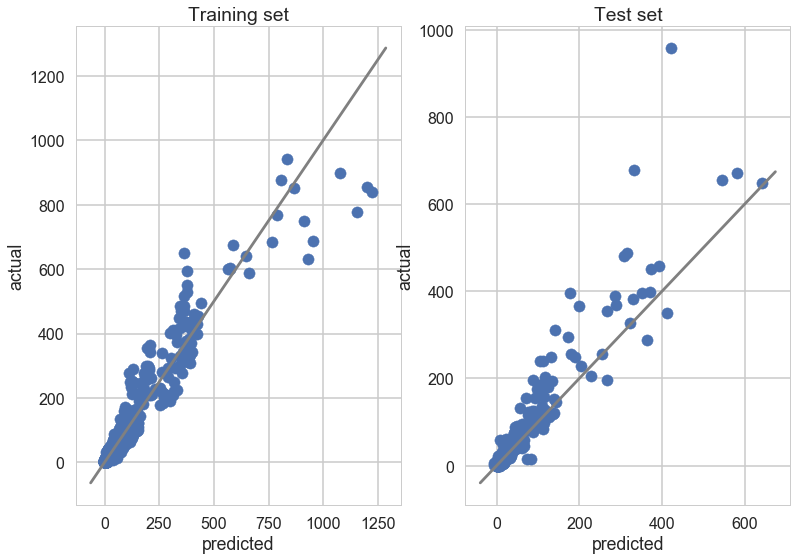

In [6]:
sns.set_context("poster")
plt.subplot(1, 2, 1)
plt.scatter(model.predict(x_train)/one_million *population_train, 
            y_train_count)
plt.title("Training set")
plt.ylabel("actual")
plt.xlabel("predicted")
plt.plot(plt.gca().get_xlim(), plt.gca().get_xlim(), color="gray")

plt.subplot(1, 2, 2)
plt.scatter(model.predict(x_test)/one_million*population_test, 
            y_test_count)
plt.title("Test set")
plt.ylabel("actual")
plt.xlabel("predicted")
plt.plot(plt.gca().get_xlim(), plt.gca().get_xlim(), color="gray")
plt.show()

Because Ridge is an extension of OLS, it is easy to interpret the coefficients on each of the variables, shown below:

In [7]:
df_coef_lin = pd.DataFrame(dict(variable = x_train.columns,
                            coef = model.coef_))
df_coef_lin = df_coef_lin.sort_values("coef")
df_description = get_descriptions(list(df_coef_lin["variable"]), df_meta)
df_coef_lin = pd.merge(df_coef_lin,df_description, how="left")

l_obs = [0,1,2,3,4,5,6,7,-7,-8,-6,-5,-4,-2,-1]
df_coef_lin.iloc[l_obs,:]

,coef,variable,description
0,-17.893939,S06_HC02_EST_VC25,Native; born in state of residence; Estimate; ...
1,-13.458215,pop_language_english,NaN
2,-11.053142,S06_HC02_EST_VC20,Native; born in state of residence; Estimate; ...
3,-10.569383,S06_HC03_EST_VC29,Native; born in other state in the U.S.; Estim...
4,-6.791582,S12_HC02_EST_VC33,Now married (except separated); Estimate; NATI...
5,-6.242251,S06_HC01_EST_VC25,Total; Estimate; RACE AND HISPANIC OR LATINO O...
6,-4.989624,S06_HC03_EST_VC25,Native; born in other state in the U.S.; Estim...
7,-4.748157,S12_HC01_EST_VC30,"Total; Estimate; White alone, not Hispanic or ..."
1134,2.044579,S25_HC02_EST_VC24,Owner-occupied housing units; Estimate; HOUSEH...
1133,2.001245,S19_HC03_EST_VC13,Married-couple families; Estimate; Median inco...


Visually:

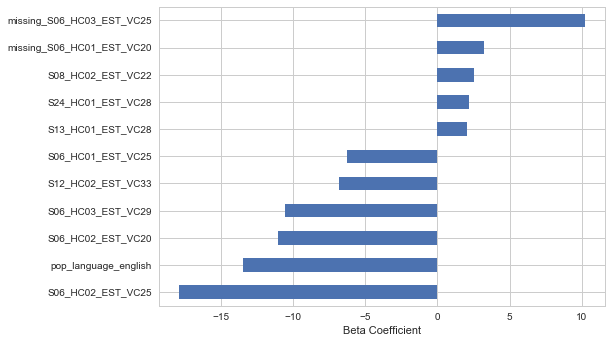

In [8]:
sns.set_context("notebook")

l_obs = [0,1,2,3,4,5,-6,-5,-4,-2,-1]
coef_lin = df_coef_lin.iloc[l_obs,:]["coef"]
coef_lin.index = df_coef_lin.iloc[l_obs,:]["variable"]
plot_coef_lin = coef_lin.plot(kind="barh")
plot_coef_lin.set(xlabel="Beta Coefficient", ylabel="")
plt.show()

Notably these values are quite large (many MSAs only had 10 or fewer murders). This suggests that these features are doing real "work" in the prediction, which is not therefore driven exclusively by the total population term.

## Conclusions

## Methodological Appendix

In addition to the procedures described above:
- Missing data were imputed when fewer than 20% of observations were available
- When imputing data we took the mean of the training set and added a corresponding dummy variable
- Features were standardized to the mean and standard deviation of the training set